# Using `sklearn` Pipelines for Custom Data Transformations

The purpose of this notebook is to demonstrate how to perform custom data transformations and analyses using `sklearn` Pipelines.  The relevant Python pseudo-code looks something like this:

```python
# Let's write a custom data transformer as an example!
from sklearn.base import BaseEstimator, TransformerMixin

# The code looks something like this:
class MyMovingAverageAdder(BaseEstimator, TransformerMixin):
    """
    Custom data transformer, intended to be used as part of a `sklearn` Pipeline.
    
    See file `./technical_analysis.py` contained in this directory for more details.
    """
    ...

```

In the code snippet shown above, there are two important points: 

2. The custom class inherits from `sklearn.base.BaseEstimator` so that we may gain methods `get_params()` and `set_params()`, which are useful in hyperparameter optimization, for example.  
1. The custom class inherits from `sklearn.base.TransformerMixin` so that we may gain methods `fit()`, `transform()`, and `fit_transform()`, which are useful in creating data-transformation pipelines, for example.

More information can be found in [sklearn.base](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20base#module-sklearn.base).


In [1]:
# Autoreload modules we're working on so that changes propagate to this notebook
%load_ext autoreload
%autoreload 1
%aimport technical_analysis

In [2]:
# Import the usual suspects....
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline


import pandas_datareader as pdr
import datetime as dt
import quandl


import pandas as pd
import numpy as np
import requests
from termcolor import colored as cl
from math import floor
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [3]:
# Here is our custom code!
from technical_analysis import *
from technical_analysis_m import *

## Generate Synthetic Test Data

In [4]:
# Define "percent" and other units & shorthands (for clarity below)
percent = 0.01
usd = 1.0  # $US

# Generate some test data
returns_mean = 0.0 * percent
returns_std = 1.0 * percent
num_business_days = 252
initial_price = 200 * usd
returns = returns_mean + (returns_std * np.random.randn(num_business_days))
timeseries = initial_price * (1 + pd.DataFrame(data=returns, columns=['close'])).cumprod()
X = timeseries.copy()  # shorthand

# Display test data
X.head()

,close
0,203.508747
1,203.312003
2,205.901861
3,204.684547
4,207.462551


In [5]:
# ticker0 = quandl.get("EOD/AAPL", authtoken="YA4KnPAgb7_ouvkkyxKs")
# # print(ticker0.size )
# ticker1 = ticker0.copy()
# ticker1.columns= ticker0.columns.str.strip().str.lower()
# ticker = ticker1.iloc[-30:]
# print(ticker.size)
# ticker.tail()

In [6]:
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
import pandas as pd

# https://algotrading101.com/learn/alpaca-trading-api-guide/
load_dotenv("C:\\Users\\thebe\\Fintech\\API_KEYS.env")

# authentication and connection details
# print(os.getenv("ALPACA_API_KEY"))
api_key = os.getenv("ALPACA_API_KEY")
api_secret = os.getenv("ALPACA_SECRET_KEY")
base_url = 'https://paper-api.alpaca.markets'

# instantiate REST API
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

# obtain account information
account = api.get_account()
# print(account)

In [7]:

today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()

# tickers = ["FB", "TWTR", 'AAPL']
tickers = ['AAPL']
# tickers =["FB"]

timeframe = "1D"



start = pd.Timestamp("2017-07-2", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-07-2", tz="America/New_York").isoformat()

# Get current closing prices for FB and TWTR
ticker0 = api.get_barset(
    tickers,
    timeframe,
    start = start,
    end = end,
).df

ticker = ticker0.copy()
ticker.columns= ticker0["AAPL"].columns.str.strip().str.lower()


# Display sample data
ticker.head(5)

,open,high,low,close,volume
time,,,,,
2021-02-10 00:00:00-05:00,136.48,136.99,134.4000,135.36,66856066
2021-02-11 00:00:00-05:00,135.90,136.39,133.7700,135.12,59377028
2021-02-12 00:00:00-05:00,134.35,135.53,133.6921,135.38,54861442
2021-02-16 00:00:00-05:00,135.49,136.01,132.7900,133.16,72596290
2021-02-17 00:00:00-05:00,131.25,132.22,129.4700,130.84,92298227


In [8]:
def get_macd(price):
    exp1 = price.ewm(span = 12, adjust = False).mean()
    exp2 = price.ewm(span = 26, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = 9, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames = [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df


In [9]:
get_macd(ticker['close'])

,macd,signal,hist
time,,,
2021-02-10 00:00:00-05:00,0.000000,0.000000,0.000000
2021-02-11 00:00:00-05:00,-0.019145,-0.003829,-0.015316
2021-02-12 00:00:00-05:00,-0.013186,-0.005700,-0.007486
2021-02-16 00:00:00-05:00,-0.185461,-0.041653,-0.143809
2021-02-17 00:00:00-05:00,-0.503392,-0.134001,-0.369392
...,...,...,...
2021-06-28 00:00:00-04:00,1.836749,1.199744,0.637005
2021-06-29 00:00:00-04:00,2.059086,1.371612,0.687473
2021-06-30 00:00:00-04:00,2.258476,1.548985,0.709491


In [10]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]


In [11]:
get_rsi(ticker['close'], lookback=14)

,rsi
time,
2021-02-17 00:00:00-05:00,4.672664
2021-02-18 00:00:00-05:00,3.729070
2021-02-19 00:00:00-05:00,6.213221
2021-02-22 00:00:00-05:00,3.496089
2021-02-23 00:00:00-05:00,3.428805
...,...
2021-06-28 00:00:00-04:00,66.014393
2021-06-29 00:00:00-04:00,69.242760
2021-06-30 00:00:00-04:00,70.411371


## Build Custom Transformation Pipeline

In [12]:
# Build an `sklearn.pipeline.Pipeline`
pipeline = Pipeline([
    ('sma20', MovingAverageAdder(ma_type='sma', window=20)),  # simple moving average (SMA)
    ('ema20', MovingAverageAdder(ma_type='ema', window=20)),  # exponential moving average (EMA)
    ('dema20', MovingAverageAdder(ma_type='dema', window=20)),  # double exponential moving average (DEMA)
    ('tema20', MovingAverageAdder(ma_type='tema', window=20)),  # triple exponential moving average (TEMA)
    ('stochastic oscillator', MarcusIndicators(ma_type='stochastic oscillator', window=20)),
    ('ichimoku cloud', MarcusIndicators(ma_type='ichimoku cloud', window=20)),
    ('fibonacci retracement', MarcusIndicators(ma_type='fibonacci retracement', window=20)),
    ('bollinger_band', BennyIndicators(indicator='bollinger_bands', bb_window=20)),
    ('rsi', BennyIndicators(indicator='rsi', lookback=14)),
    ('macd', BennyIndicators(indicator='macd'))
])

## Transform Data

In [13]:
# Transform the input data
# X_transformed = pipeline.fit_transform(X)

In [14]:
ticker_transformed = pipeline.fit_transform(ticker)

Level Percentage	 Price ($)
00.0%		 139.96
23.6%		 134.39984
38.2%		 130.96008
50.0%		 128.18
61.8%		 125.39992000000001
100.0%		 116.4


In [15]:
# X_transformed.plot()

<AxesSubplot:xlabel='time'>

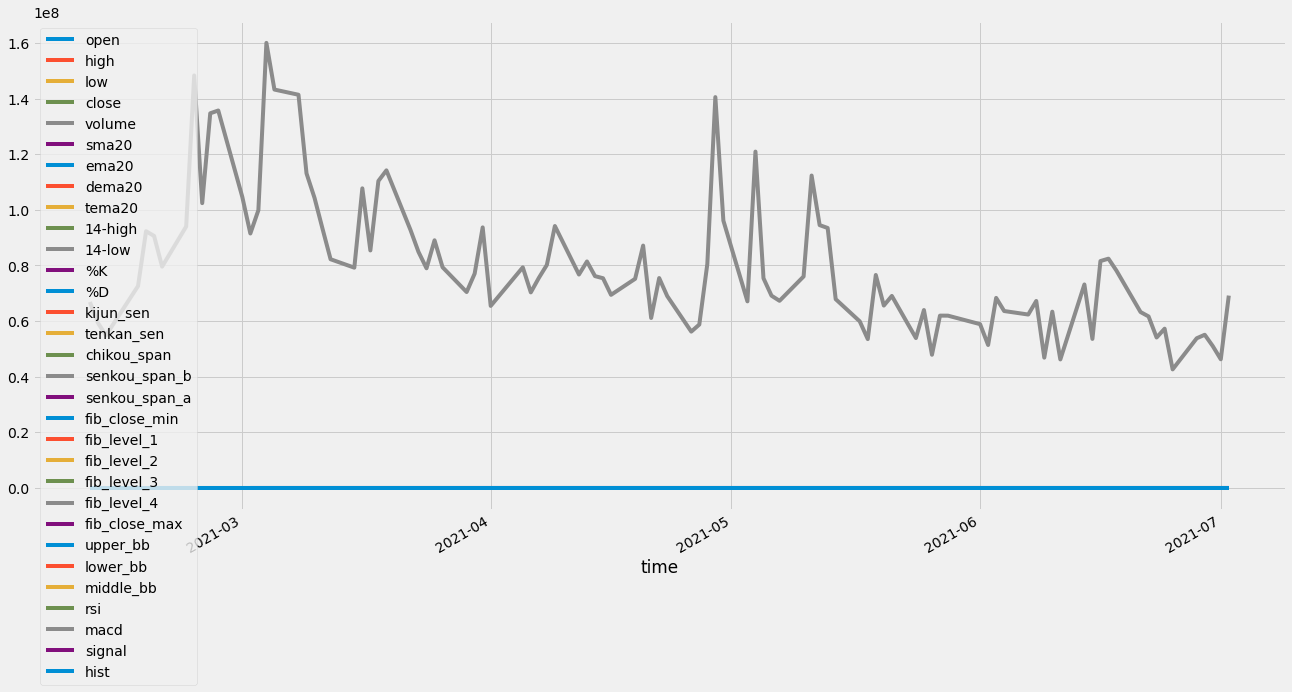

In [16]:
ticker_transformed.plot()

In [17]:
# X_transformed.tail()

In [18]:
ticker_transformed.tail()

,open,high,low,close,volume,sma20,ema20,dema20,tema20,14-high,...,fib_level_3,fib_level_4,fib_close_max,upper_bb,lower_bb,middle_bb,rsi,macd,signal,hist
time,,,,,,,,,,,,,,,,,,,,,
2021-06-28 00:00:00-04:00,133.42,135.245,133.350,134.75,53815255,129.293355,130.559431,132.764396,134.368304,135.245,...,128.18,125.39992,139.96,136.472765,122.113945,129.293355,66.014393,1.836749,1.199744,0.637005
2021-06-29 00:00:00-04:00,134.82,136.490,134.350,136.33,55081959,129.894855,131.109042,133.601171,135.312259,136.490,...,128.18,125.39992,139.96,137.324219,122.465491,129.894855,69.242760,2.059086,1.371612,0.687473
2021-06-30 00:00:00-04:00,136.17,137.410,135.870,136.94,51014239,130.487355,131.664402,134.421547,136.209596,137.410,...,128.18,125.39992,139.96,138.188410,122.786300,130.487355,70.411371,2.258476,1.548985,0.709491
2021-07-01 00:00:00-04:00,136.60,137.330,135.760,137.27,46267213,131.173105,132.198295,135.175796,136.993094,137.410,...,128.18,125.39992,139.96,138.715914,123.630296,131.173105,71.052150,2.415282,1.722245,0.693037
2021-07-02 00:00:00-04:00,137.92,140.000,137.745,139.96,69160944,131.877105,132.937538,136.300201,138.293086,140.000,...,128.18,125.39992,139.96,139.949496,123.804714,131.877105,75.676334,2.725197,1.922835,0.802362


## Plot Results

In [19]:
# Plot the results
#ax = X_transformed.plot(linewidth=1.5)
# ax = X_transformed.rename(columns={'close': 'close (input)'}).plot()
# ax.set_title('Stock Price vs. Time (Synthetic Data)')
# ax.set_xlabel('Number of Business Days')
# ax.set_ylabel('Stock Price ($US)')
# ax.legend(title='Pipeline Results', ncol=1)
# plt.show()

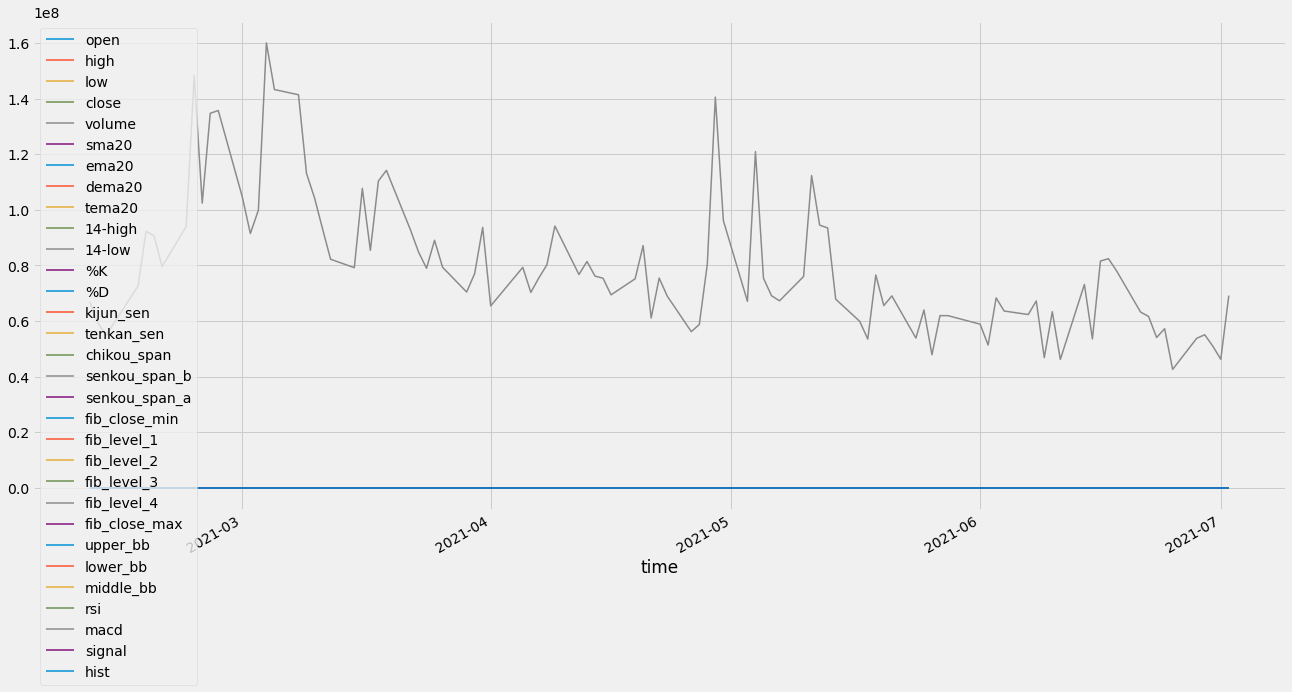

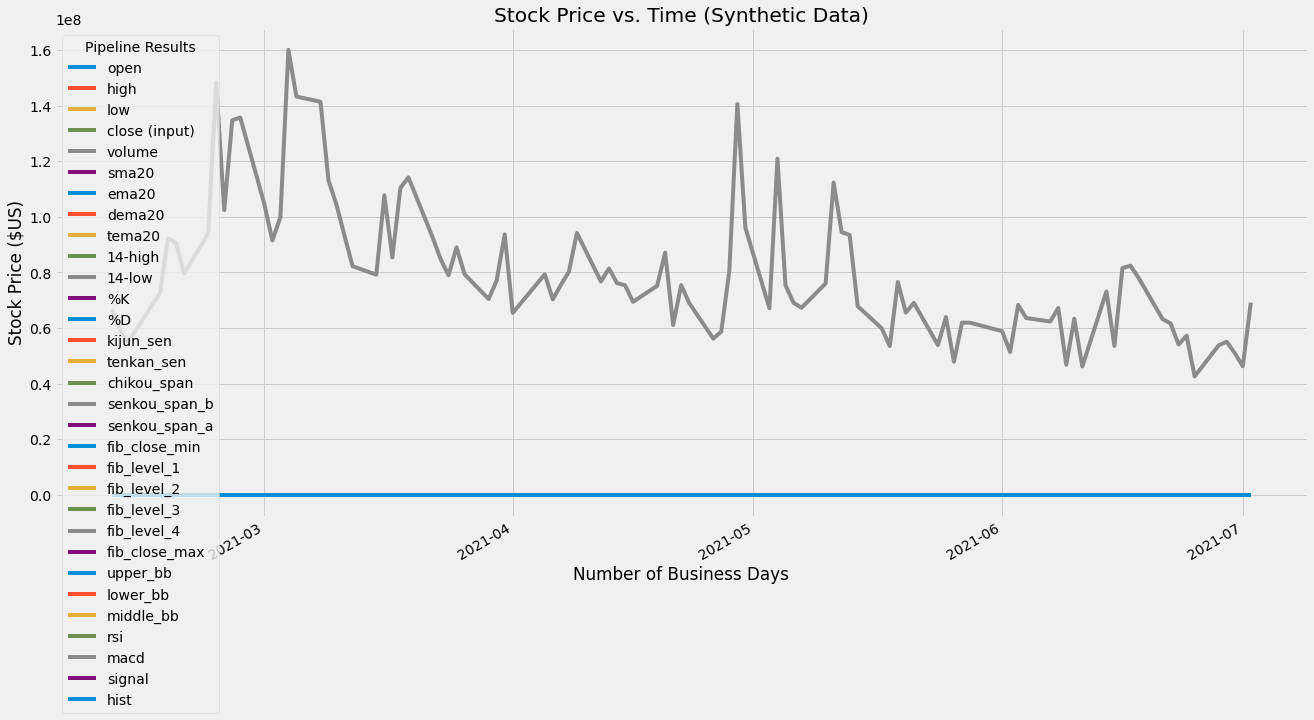

In [20]:
# Plot the results
ax = ticker_transformed.plot(linewidth=1.5)
ax = ticker_transformed.rename(columns={'close': 'close (input)'}).plot()
ax.set_title('Stock Price vs. Time (Synthetic Data)')
ax.set_xlabel('Number of Business Days')
ax.set_ylabel('Stock Price ($US)')
ax.legend(title='Pipeline Results', ncol=1)
# plt.show()

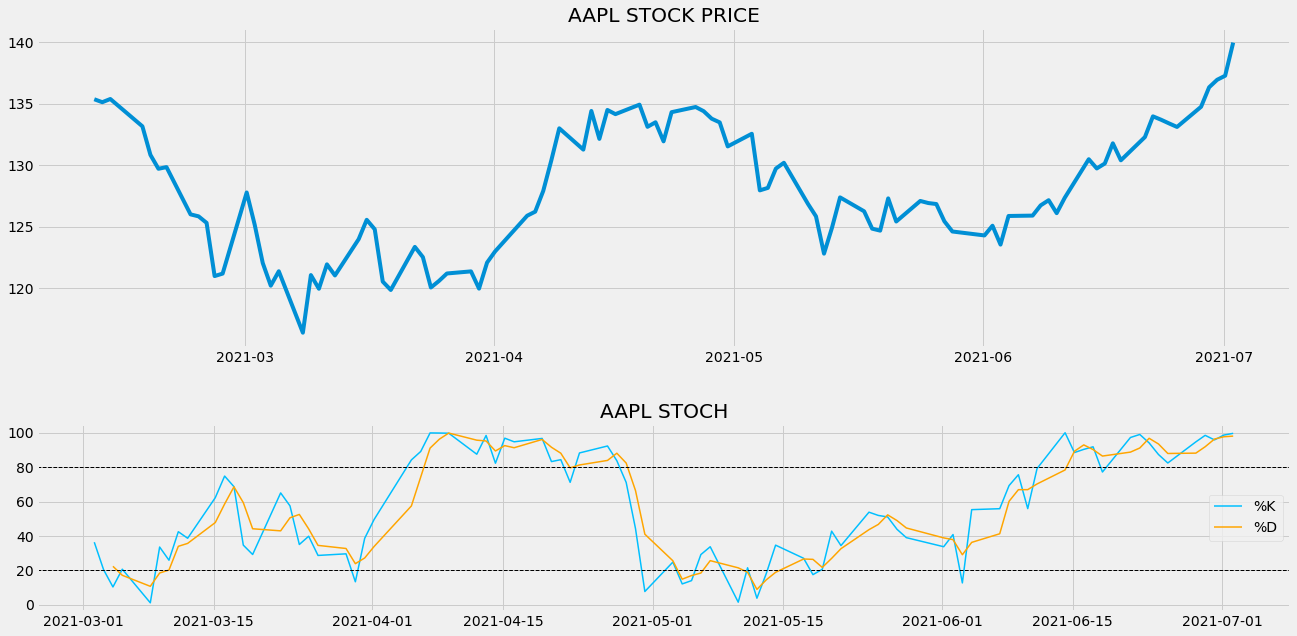

In [21]:
# from matplotlib import pyplot as plt
plot_stoch('AAPL', ticker_transformed['close'], ticker_transformed['%K'],ticker_transformed['%D'])

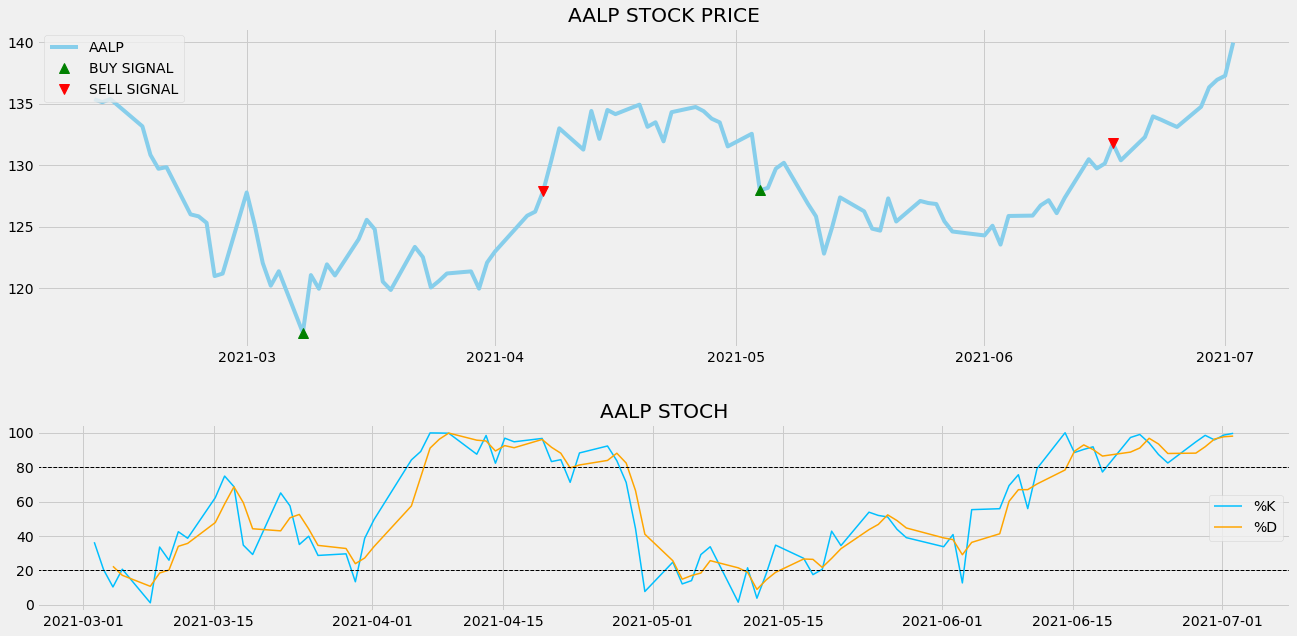

In [22]:
buy_price, sell_price, stoch_signal = implement_stoch_strategy(ticker_transformed['close'], ticker_transformed['%K'], ticker_transformed['%D'])
plot_sell_buy(ticker_transformed, buy_price, sell_price, stoch_signal)

# Ichimoku Cloud Plot


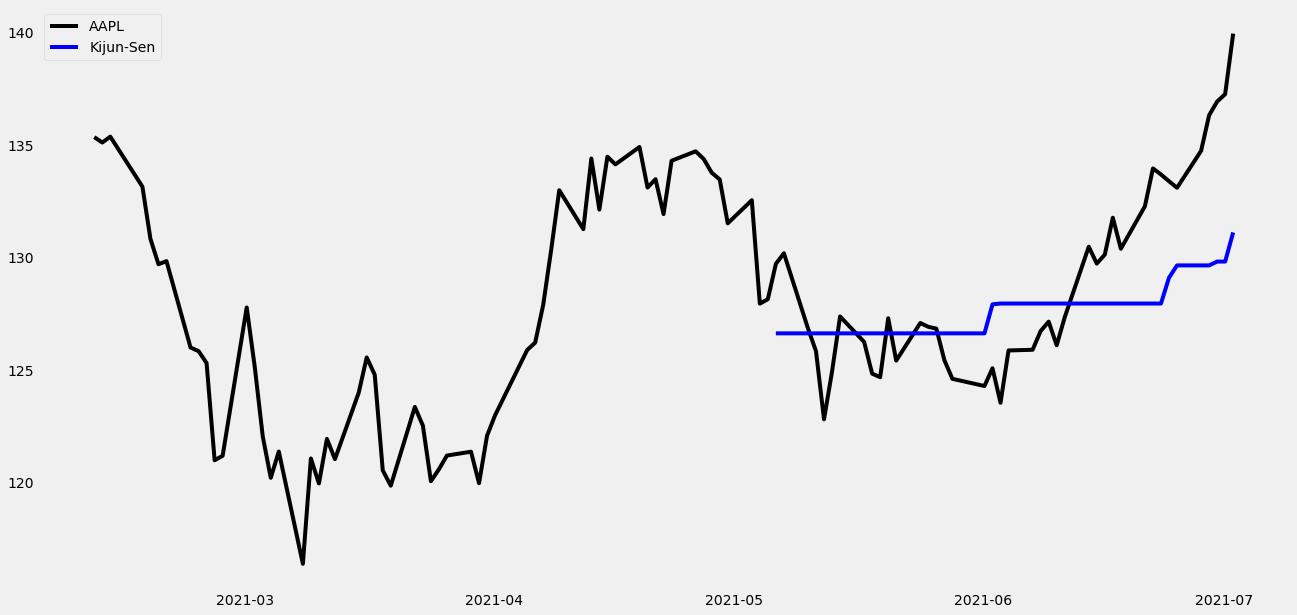

In [23]:
kijun_sen_plot(ticker_transformed,kijun_window)

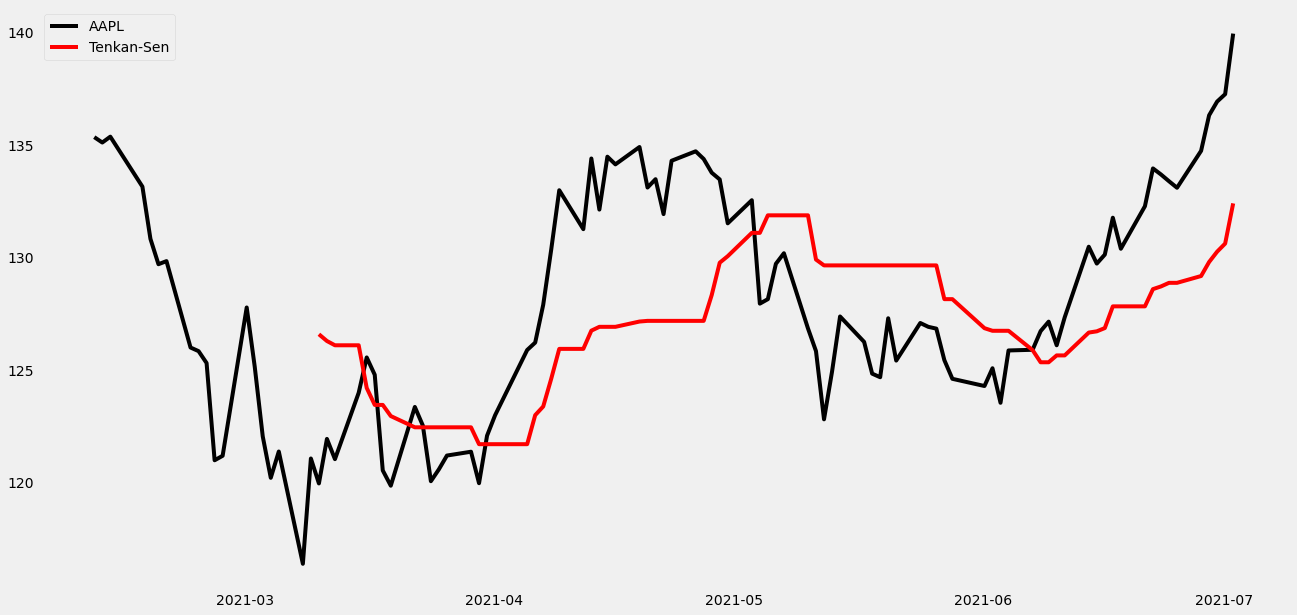

In [24]:
tenkan_sen_plot(ticker_transformed, tenkan_window )

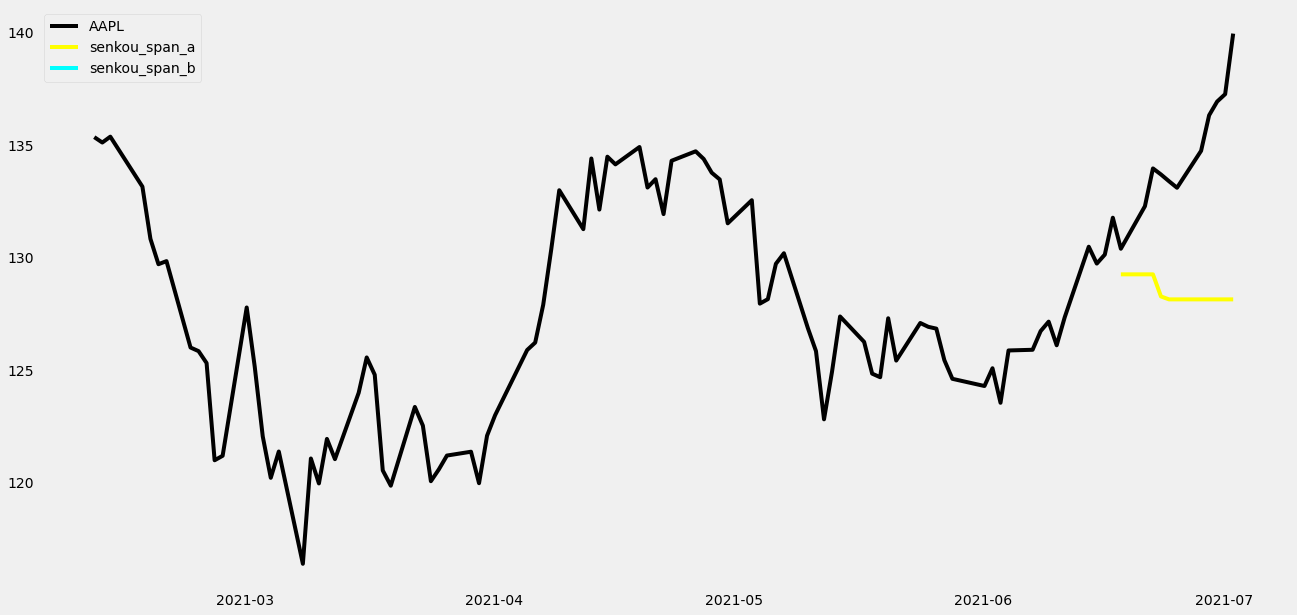

In [25]:
Senkou_Span_plot(ticker_transformed, senkou_span_b_window)

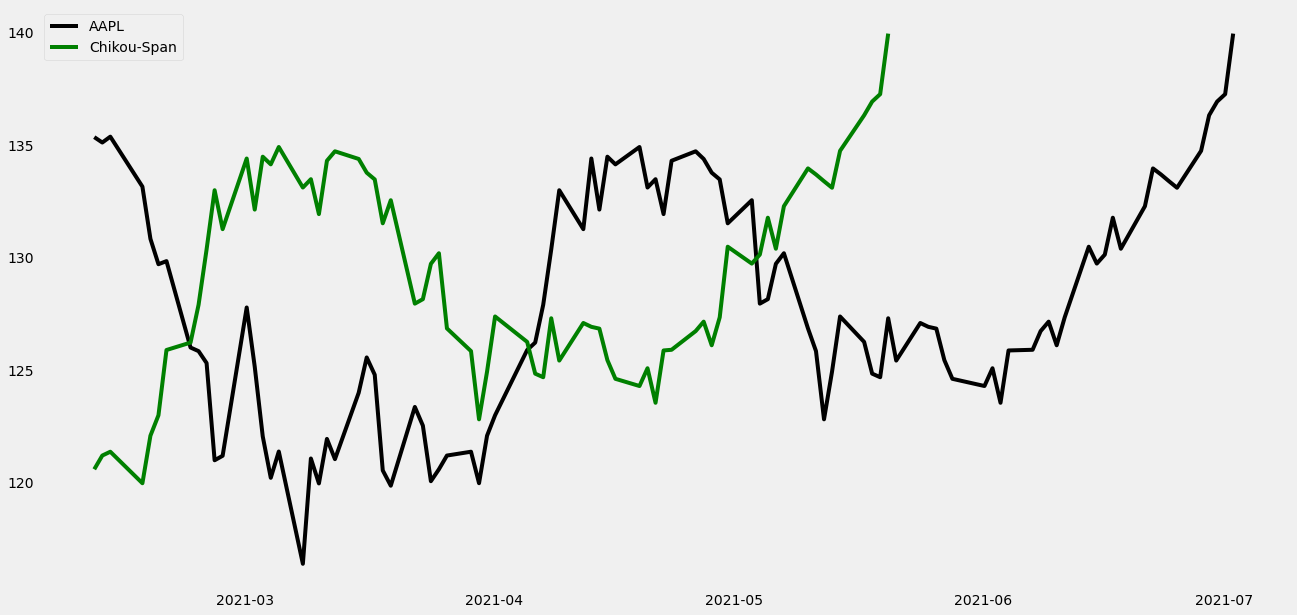

In [26]:
Chikou_plot(ticker_transformed, chikou_shift)

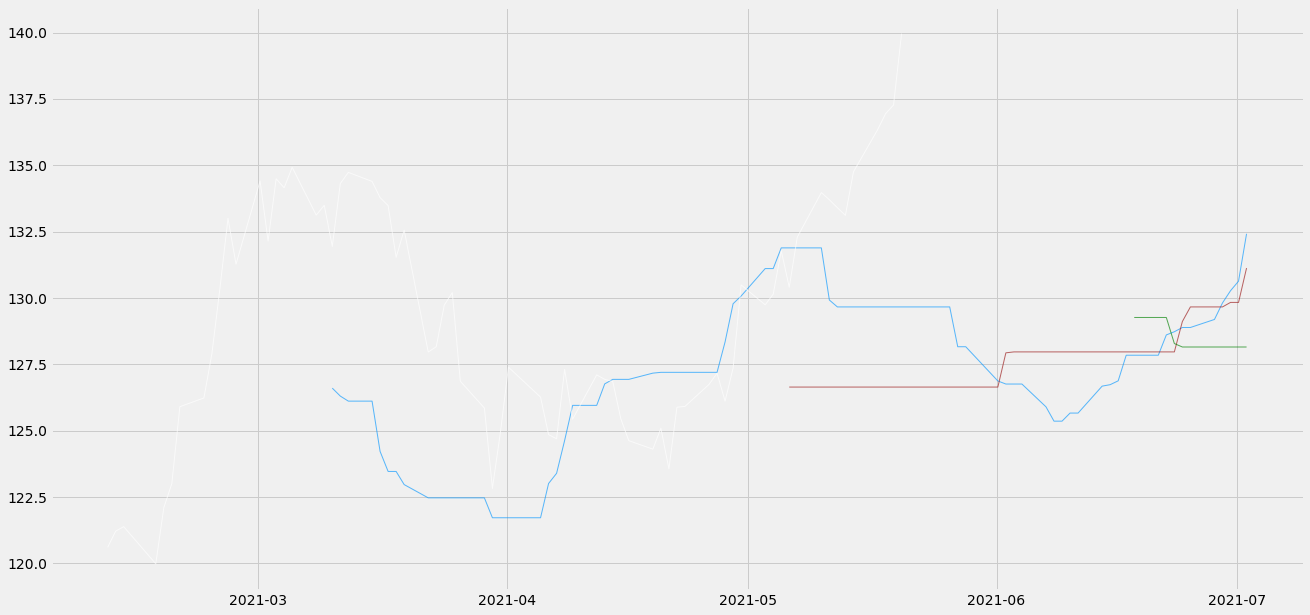

In [27]:
plot_ichimoku(ticker_transformed,  view_limit=100)

# Fibonacci Retracement Plot

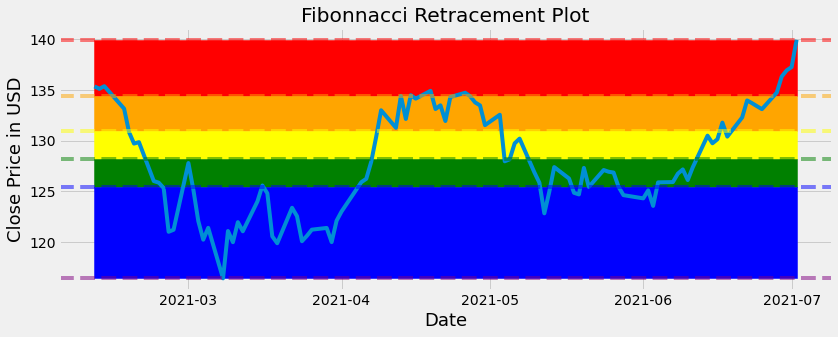

In [28]:

fib_retracement_plot(
    ticker_transformed,
    ticker_transformed['fib_close_min'][0],
    ticker_transformed['fib_level_1'][0],
    ticker_transformed['fib_level_2'][0], 
    ticker_transformed['fib_level_3'][0],
    ticker_transformed['fib_level_4'][0],
    ticker_transformed['fib_close_max'][0])